Note: **Source code berfokus pada proses klasifikasi saham bagi emiten BBRI saja**

# News Data

## Collecting News Data

In [ ]:
!pip install Gnews

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.4/188.4 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=c1dbab8b89651f5f0a57685336010fa004a30b29443137c447f16b815a06b208
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [ ]:
import datetime
import pandas as pd
from gnews import GNews
import nltk
from google.colab import drive
drive.mount('/content/drive')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Define your start_date and end_date
end_date = datetime.date(2023, 9, 30)
start_date = end_date - datetime.timedelta(days=365*5)  # Limit to the past year

# Change the parameters based on the desired stock and site
# All emiten = [BBRI, BMRI, BBCA, BBNI, BBTN, SMGR, BRPT, INTP, INKO, MDKA]
stock = "BBRI"
web = "Bisnis"

link_cnbc = "site:cnbcindonesia.com"
link_bisnis = "site:bisnis.com"
link_kontan = "site:kontan.co.id"

# Initialize an empty list to store news data
all_news = []

# Define the number of days to fetch news in each iteration
delta = datetime.timedelta(days=7)  # You can adjust this as needed

# Initialize variables for tracking consecutive equal values
prev_total_data = 0
consecutive_equal_count = 0
max_consecutive_equal_count = 100  # Change this to set the desired threshold

In [ ]:
# Data collecting process using GNews
google_news = GNews(language='id', country='ID')

while end_date >= start_date and consecutive_equal_count < max_consecutive_equal_count:
    # Fetch news for the current date range
    news_query = f"{link_bisnis} {stock} after:{end_date - delta} before:{end_date}" # Change the link based on the desired site
    list_news_bisnis = google_news.get_news(news_query)

    if list_news_bisnis:
        # Assume news are sorted by date, which might need verification
        most_recent_date = list_news_bisnis[0]['published date']
        print(f"Most recent published_date in this iteration: {most_recent_date}")

        # Initialize a list to store all news items for this iteration
        news_items = []

        for news in list_news_bisnis:
            title = news['title']
            if "BBRI" in title or "BRI" in title or "Bank Rakyat Indonesia" in title:
                news_item = {
                    'published_date': news['published date'],
                    'title': title
                }
                news_items.append(news_item)

        # Append all news items for this iteration to the main list
        all_news.extend(news_items)

    # Update the end_date for the next iteration
    end_date -= delta

    # Get the current total data obtained
    total_data = len(all_news)
    print(f"Total data obtained so far: {total_data}")

    # Check if the current total data is equal to the previous total data
    if total_data == prev_total_data:
        consecutive_equal_count += 1
    else:
        consecutive_equal_count = 0  # Reset the counter if they are not equal

    # Update the previous total data
    prev_total_data = total_data

# Output all news gathered
print("All news collected:")
for news in all_news:
    print(news)

Most recent published_date in this iteration: Mon, 11 Sep 2023 07:00:00 GMT
Total data obtained so far: 1
Most recent published_date in this iteration: Sat, 02 Sep 2023 07:00:00 GMT
Total data obtained so far: 3
Most recent published_date in this iteration: Thu, 31 Aug 2023 07:00:00 GMT
Total data obtained so far: 3
Most recent published_date in this iteration: Thu, 24 Aug 2023 07:00:00 GMT
Total data obtained so far: 3
Most recent published_date in this iteration: Tue, 15 Aug 2023 07:00:00 GMT
Total data obtained so far: 4
Most recent published_date in this iteration: Wed, 09 Aug 2023 07:00:00 GMT
Total data obtained so far: 6
Most recent published_date in this iteration: Thu, 03 Aug 2023 07:00:00 GMT
Total data obtained so far: 6
Most recent published_date in this iteration: Fri, 21 Jul 2023 07:00:00 GMT
Total data obtained so far: 9
Most recent published_date in this iteration: Tue, 12 Sep 2023 04:52:36 GMT
Total data obtained so far: 11
Most recent published_date in this iteration:

In [ ]:
from datetime import datetime

# Create a DataFrame from the list of dictionaries
df_news = pd.DataFrame(all_news)

# Remove the publisher from the title column
df_news['title'] = df_news['title'].apply(lambda x: x.split(' - ')[0])

# Define a function to format the date
def format_date(date_str):
    # Convert the string to a datetime object
    date_obj = datetime.strptime(date_str, '%a, %d %b %Y %H:%M:%S %Z')
    # Format the datetime object to display only the date
    return date_obj.strftime('%d %b %Y')

# Apply the function to the "published date" column
df_news['published_date'] = df_news['published_date'].apply(format_date)
df_news['published_date'] = pd.to_datetime(df_news['published_date'], format='%d %b %Y')
df_news['publisher'] = web
df_news['kode_emitten'] = stock
df_news = df_news.sort_values(by='published_date', ascending=False)

In [ ]:
# Detect duplicate values in the "title" column
duplicate_mask = df_news['title'].duplicated(keep='first')
print(f'number of duplicated rows is = {duplicate_mask.sum()}')

number of duplicated rows is = 21


In [ ]:
# Remove the duplicates
df = df_news[~duplicate_mask]
df.reset_index(drop=True, inplace=True)

In [ ]:
# Save and combine the dataset after collecting and combining all the site
# df.to_csv(f'./Dataset/BBRI/Sentiment/All_BBRI.csv')

## Preprocessing

In [ ]:
!pip install deep-translator

In [ ]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer

import string
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
pd.set_option('display.max_colwidth', None)
stopwords_en = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [ ]:
dic = {   "genjot" : "boost",
          "jumbo" : "huge",
          "pede" : "confident",
          "karya" : "works",
          "gede" : "large",
          "borong" : "wholesale",
          "cuan" : "profit",
          "bos" : "boss",
          "pegadaian" : "pawnshop",
          "liga" : "league",
          "syariah" : "sharia",
          "sabet" : "achieved",
          "serok" : "scoop",
          "pas" : "just right",
          "laku" : "in demand",
          "ciamik" : "cool",
          "cuanthis" : "profit",
          "cuanbri" : "profit",
          "bansos" : "social assistance",
          "mudik" : "going home",
          "santuni" : "supports",
          "sekuritas" : "securities",
          "iduladha" : "eid",
          "bangkit" : "rise",
          "niaga" : "commerce",
          "aset" : "asset",
          "adu" : "contest",
          "batang" : "pole",
          "danareksa" : "mutual funds",
          "danareksas" : "mutual funds",
          "mengukur" : "measure",
          "karat" : "carat",
          "pandemi" : "pandemic",
          "pandemithis" : "pandemic",
          "gokil" : "amazing",
          "pangling" : "overlook",
          "untung" : "profit",
          "aprofit" : "profit",
          "keroyok" : "buy",
          "kerisean" : "seriousness",
          "kabar" : "news",
          "bidik" : "aim",
          "sinergi" : "chemistry",
          "melek" : "awake",
          "salip" : "overtake",
          "tangguh" : "tough",
          "merdeka" : "freedom",
          "makmur" : "prosperous",
          "bisnis" : "business",
          "kempit" : "cramped",
          "disabilitas" : "disabled",
          "sahabat" : "close friends",
          "sembako" : "basic necessities",
          "bunga" : "interest",
          "raut" : "expression",
          "gandeng" : "collaborate",
        }

In [ ]:
from deep_translator import GoogleTranslator

# Function to clean the text
def clean_punctuations(row, col):

    sentence = row[col]
    sentence = sentence.lower()
    sentence = re.sub(r'(?<=[.,])(?=[^\s])', r'\. ', sentence)
    sentence = re.sub(r"\d+", "", sentence)
    sentence = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', sentence)
    trans = str.maketrans("","",string.punctuation)
    sentence = sentence.translate(trans)
    sentence = re.sub(r'\s+',' ',sentence)
    sentence = word_tokenize(sentence)
    sentence = [word for word in sentence if not word in stopwords_en]
    sentence = [lemmatizer.lemmatize(word) for word in sentence]

    corpus = " ".join(sentence)

    return corpus

# Function to translate the news title
def enhanced_translate(text, custom_dict, source_lang='auto', target_lang='en'):
    # First, translate the text using deep-translator
    translated_text = GoogleTranslator(source=source_lang, target=target_lang).translate(text)

    # Then, split the translated text into words and replace using the custom dictionary
    words = translated_text.split()
    final_translation = ' '.join([custom_dict.get(word.lower(), word) for word in words])

    return final_translation

In [ ]:
# Import the previously obtained news data
df = pd.read_csv(f'./Dataset/BBRI/Sentiment/All_BBRI.csv')
df = df.drop(columns=['Unnamed: 0'], axis=1)

# Convert 'published_date' to datetime format (if not already)
df['published_date'] = pd.to_datetime(df['published_date'])

# Sort the DataFrame based on the index (oldest to most recent)
df.sort_index(inplace=True)

In [ ]:
# Apply translation
df['title_en'] = df['title'].apply(lambda x: enhanced_translate(x, dic))
df['title_en']

0                                                   Suwarna Arta Mandiri buys shares in freedom Copper Gold
1                                            Legal, Provident Agro (PALM) Buys freedom Copper (MDKA) Shares
2                                                          SRTG Sells Shares in MDKA for IDR 309.12 Billion
3                                        freedom Copper Gold (MDKA) Performance is Great, Analysts Say This
4                                         freedom Copper Gold (MDKA) Pockets Net Profit of US$32.56 Million
                                                       ...                                                 
158                                    freedom Copper Gold (MDKA) Ready to Operate Underground Mine in 2027
159                     Take a peek at the giant freedom Copper gold mine, this is how much production goes
160                   Subsidiary freedom Copper Gold (MDKA) Boosts Gold and Copper Production in Banyuwangi
161                  Looking

In [ ]:
# Save the translated data
# df.to_csv(f'./Dataset/BBRI/Sentiment/All_BBRI_translated.csv')

In [ ]:
# Select 200 random rows to manually label it
random_rows = df.sample(n=200, random_state=42)  # random_state for reproducibility

# Create a new DataFrame from the selected rows
to_be_labeled = random_rows.copy()

# Remove the selected rows from the original DataFrame
df = df.drop(to_be_labeled.index)

# Resetting the index
df.reset_index(drop=True, inplace=True)
to_be_labeled.reset_index(drop=True, inplace=True)

# Save the new dataset with no manual labels
# df.to_csv(f'./Dataset/BBRI/Sentiment/All_BBRI_NoManual_translated.csv')

# Save the rest 200 datasets and manually label it after
# to_be_labeled.to_csv(f'./Dataset/BBRI/Sentiment/Manual_Labeled_BBRI.csv')

## Pseudolabeling

In [ ]:
!pip install torch
!pip install accelerate -u
!pip install scikit-learn
!pip install transformers
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.4/251.4 kB 1.8 MB/s eta 0:00:00


### Import Data

In [ ]:
import pandas as pd

# Import manually labeled dataset for the initial training data to finetune pseudolabeling model
df = pd.read_csv(f'./Dataset/BBRI/Sentiment/Manual_Labeled_BBRI.csv')
df = df.drop(columns=['Unnamed: 0'], axis=1)

df_en = df[["title", "title_en", "manual_label"]].copy()
df_en.reset_index(drop=True, inplace=True)
df_en.rename(columns={'title_en': 'text', 'manual_label': 'label'}, inplace=True)

df_en

,title,text,label
0,"Cara Daftar dan Syarat Program Mudik Gratis BRI, BTN, dan Pegadaian 2022","How to Register and Terms of Free Home Home BRI, BTN, and Pawnshop 2022 programs",0
1,BRI Surabaya Bidik 4.000 Merchant EDC Baru di Ajang SSF 2023,"BRI Surabaya Aim 4,000 New EDC Merchant at the SSF 2023 event",0
2,BRI Andalkan BRI Spot untuk Dongkrak Kredit Mikro,BRI Rely on BRI Spot for Micro Credit Jack,0
3,"IHSG Belum Aman, Pantau Saham BBRI, SMGR, MIKA, ICBP, INDF","JCI is not safe, Monitor BBRI, SMGR, MIKA, ICBP, INDF shares",0
4,"Jadi BUMN Terbaik, BRI Borong 8 Penghargaan Kehumasan","So the best BUMN, BRI Wholesale 8 Public Relations Awards",1
...,...,...,...
195,"Borong 3 Penghargaan, BRI Raih Pengakuan Internasional","wholesale 3 awards, BRI achieved international recognition",1
196,"Holding Ultra Mikro, Saham BBRI Diprediksi Tembus Rp 5.200","Holding Ultra Micro, BBRI shares are predicted to reach Rp 5,200",0
197,"Dorong Ekonomi Desa Berkelanjutan, BRI Targetkan 1.000 Desa Jadi Desa BRILIAN","Encourage the economy of sustainable villages, BRI is targeting 1,000 villages to be Brilian Village",0
198,"Tidak Ada Bias Gender, BRI Jaga Kesetaraan Remunerasi","There is no gender bias, BRI keeps the equality of remuneration",0


In [ ]:
# Title Dataset
df_bbri = pd.read_csv(f'./Dataset/BBRI/Sentiment/All_BBRI_NoManual_translated.csv')

df_bbri = df_bbri.drop(columns=['Unnamed: 0'], axis=1)
df_bbri.rename(columns={'title_en': 'text'}, inplace=True)

df_bbri

,published_date,title,publisher,kode_emitten,text
0,2018-09-07,"Genjot Kinerja, BRI Medan Rangkul Hipmi Sumut",Bisnis,BBRI,"Boosting Performance, BRI Medan Embraces Hipmi..."
1,2018-09-19,BRI Gandeng Siloam Hospitals,Bisnis,BBRI,BRI Collaborates with Siloam Hospitals
2,2018-09-28,"Anak Usaha Dicaplok BRI, Danareksa Masih Calon...",Bisnis,BBRI,"Subsidiary Annexed by BRI, mutual funds Still ..."
3,2018-10-07,BRI berikan pinjaman non cash loan US$ 200 jut...,Kontan,BBRI,BRI provided a non-cash loan of US$ 200 millio...
4,2018-10-24,BRI Mengaku Tertarik Dengan Bank Banten,Bisnis,BBRI,BRI Claims to be Interested in Bank Banten
...,...,...,...,...,...
2163,2023-09-29,"Tingkatkan Portofolio Berkelanjutan, BRI Tempu...",CNBC Indonesia,BBRI,"Increase Sustainable Portfolio, BRI Takes This..."
2164,2023-09-29,"Investasi Industri Hijau Disebut Masih Mahal, ...",CNBC Indonesia,BBRI,"Green Industry Investment Is Still Expensive, ..."
2165,2023-09-29,Strategi & Kolaborasi BRI Dukung Net Zero Emis...,CNBC Indonesia,BBRI,BRI Strategy & Collaboration Supports Net Zero...
2166,2023-09-30,"Segini Nih, Saldo Minimum BCA, Mandiri, BRI & ...",CNBC Indonesia,BBRI,"This is the Minimum Balance for BCA, Mandiri, ..."


### Set up Functions

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.metrics import accuracy_score
from torch.nn.functional import softmax

pd.set_option('display.max_colwidth', None)

In [ ]:
# Function to evaluate the model
def evaluate_model(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = softmax(logits, dim=1)
            confidences.extend(probs.max(dim=1).values.tolist())
            predicted_labels = torch.argmax(logits, dim=1)
            predictions.extend(predicted_labels.tolist())
            true_labels.extend(labels.tolist())
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy, confidences

In [ ]:
# Function to predict labels and confidence levels
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    confidences = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = softmax(logits, dim=1)
            confidences.extend(probs.max(dim=1).values.tolist())
            predicted_labels = torch.argmax(logits, dim=1)
            predictions.extend(predicted_labels.tolist())

    return predictions, confidences

In [ ]:
# Dataset class for the starting data before finetuning
class FinBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Define the dataset class for testing the model after finetuning
class NewDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [ ]:
# Pretrained model
finbert_tone = "yiyanghkust/finbert-tone"

### Set up Pseudolabeling Loop

In [ ]:
# Initial dataset = BBRI manually labeled dataset
initial_train = df_en.copy()
initial_train

,title,text,label
0,"Cara Daftar dan Syarat Program Mudik Gratis BRI, BTN, dan Pegadaian 2022","How to Register and Terms of Free Home Home BRI, BTN, and Pawnshop 2022 programs",0
1,BRI Surabaya Bidik 4.000 Merchant EDC Baru di Ajang SSF 2023,"BRI Surabaya Aim 4,000 New EDC Merchant at the SSF 2023 event",0
2,BRI Andalkan BRI Spot untuk Dongkrak Kredit Mikro,BRI Rely on BRI Spot for Micro Credit Jack,0
3,"IHSG Belum Aman, Pantau Saham BBRI, SMGR, MIKA, ICBP, INDF","JCI is not safe, Monitor BBRI, SMGR, MIKA, ICBP, INDF shares",0
4,"Jadi BUMN Terbaik, BRI Borong 8 Penghargaan Kehumasan","So the best BUMN, BRI Wholesale 8 Public Relations Awards",1
...,...,...,...
195,"Borong 3 Penghargaan, BRI Raih Pengakuan Internasional","wholesale 3 awards, BRI achieved international recognition",1
196,"Holding Ultra Mikro, Saham BBRI Diprediksi Tembus Rp 5.200","Holding Ultra Micro, BBRI shares are predicted to reach Rp 5,200",0
197,"Dorong Ekonomi Desa Berkelanjutan, BRI Targetkan 1.000 Desa Jadi Desa BRILIAN","Encourage the economy of sustainable villages, BRI is targeting 1,000 villages to be Brilian Village",0
198,"Tidak Ada Bias Gender, BRI Jaga Kesetaraan Remunerasi","There is no gender bias, BRI keeps the equality of remuneration",0


In [ ]:
# Define function to make the next iteration train dataset
def new_train_dataset(results_df, threshold):
  new_train = results_df[results_df['confidence'] >= threshold].copy()
  new_train.rename(columns={'predicted_label': 'label'}, inplace=True)
  new_train.reset_index(drop=True, inplace=True)
  new_train = new_train[['title',	'text',	'label', 'confidence']]
  return new_train

# Define function to make the next iteration test dataset
def next_iteration_dataset(results_df, threshold):
  next_iter = results_df[results_df['confidence'] < threshold].copy()
  next_iter.rename(columns={'predicted_label': 'label'}, inplace=True)
  next_iter.reset_index(drop=True, inplace=True)
  next_iter = next_iter[['title',	'text',	'label', 'confidence']]
  return next_iter

# Define the Pseudolabeling Loop function
def pseudolabeling_loop(df_finbert_tone, next_iter, max_scrap):
  # Define FinBERT fine-tuning parameters
  MAX_LENGTH = 32
  BATCH_SIZE = 16
  EPOCHS = 3
  LEARNING_RATE = 1e-5
  threshold = 0.95
  count_len = []
  avg_conf_count = []

  for x in range(50):
    print("----------------------------------------------------------------------\n")
    iter = x + 1
    print(f"Entering iteration {iter}\n")
    label_encoder = LabelEncoder()
    df_finbert_tone_encode = df_finbert_tone.copy()
    df_finbert_tone_encode['label'] = label_encoder.fit_transform(df_finbert_tone_encode['label'])

    # Split the dataset into train and validation sets
    train_df, val_df = train_test_split(df_finbert_tone_encode, test_size=0.1, random_state=1)

    # Load model
    tokenizer = BertTokenizer.from_pretrained(finbert_tone)
    model = BertForSequenceClassification.from_pretrained(finbert_tone, num_labels=len(label_encoder.classes_))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Prepare data loaders
    train_dataset = FinBERTDataset(train_df['text'].tolist(), train_df['label'].tolist(), tokenizer, MAX_LENGTH)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = FinBERTDataset(val_df['text'].tolist(), val_df['label'].tolist(), tokenizer, MAX_LENGTH)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Prepare optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*EPOCHS)

    print("Beginning Training...\n")

    # Training and validation
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        average_train_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{EPOCHS}, Average Training Loss: {average_train_loss:.4f}')

        # Validation
        val_accuracy, val_confidences = evaluate_model(model, val_loader, device)
        print(f'Epoch {epoch+1}/{EPOCHS}, Average Confidence: {sum(val_confidences)/len(val_confidences):.4f}')

    print("")

    # Load the new test data from previous iteration
    test_df = next_iter.copy()

    model.eval()  # Set model to evaluation mode
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Load your new dataset
    new_texts = test_df['text'].tolist()

    # Prepare the DataLoader
    new_dataset = NewDataset(new_texts, tokenizer, MAX_LENGTH)
    new_loader = DataLoader(new_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("Predicting Labels...\n")

    # Get predictions and confidences
    predicted_labels, confidences = predict(model, new_loader, device)

    # Decode labels back to original form
    decoded_labels = label_encoder.inverse_transform(predicted_labels)

    # Create a DataFrame with predictions and confidences
    results_df = pd.DataFrame({
        'title' : test_df['title'],
        'text': new_texts,
        'predicted_label': decoded_labels,
        'confidence': confidences
    })

    # New train dataset
    new_train = new_train_dataset(results_df, threshold)

    # Data for next iteration
    next_iter = next_iteration_dataset(results_df, threshold)

    # Detect the average, highest, and lowest confidence value
    avg_conf = sum(results_df['confidence'])/len(results_df['confidence'])
    avg_conf_count.append(avg_conf)
    print(f"Average Confidence = {avg_conf}")

    max_conf = results_df['confidence'].max()
    print(f"Current Maximum Confidence Value = {max_conf}")

    low_conf = results_df['confidence'].min()
    print(f"Current lowest Confidence Value = {low_conf}")

    # Insert the previous test length into the array
    count_len.append(len(next_iter))
    print(f"Total Data with Confidence Value below {threshold} = {len(next_iter)}")

    # Check if the current iteration data is already less than the maximum scrapped data
    if len(next_iter) <= max_scrap:

      # Combine the old trainset with the new train data
      df_finbert_tone = pd.concat([df_finbert_tone, new_train], ignore_index=True)
      print(f"Total Data with Confidence over {threshold} = {len(df_finbert_tone)}\n")
      print(f"Next iteration is already less than {max_scrap} data\n")
      print(f"Iteration stop at {iter}\n")
      print(next_iter)
      break

    # Check if the current maximum confidence level is still higher than the threshold
    if max_conf >= threshold:

      # Combine the old trainset with the new train data
      df_finbert_tone = pd.concat([df_finbert_tone, new_train], ignore_index=True)
      print(f"Total Data with Confidence over {threshold} = {len(df_finbert_tone)}\n")

      continue
    else:
      if threshold == 0.95:
        # Lower threshold to 90%
        print(f"Threshold lowered to 90% on iteration {iter}\n")
        threshold = 0.9

        # New train dataset
        new_train = new_train_dataset(results_df, threshold)

        # Data for next iteration
        next_iter = next_iteration_dataset(results_df, threshold)

        print(f"Total After the Threshold lowered to {threshold} = {len(next_iter)}")

        # Combine the old trainset with the new train data
        df_finbert_tone = pd.concat([df_finbert_tone, new_train], ignore_index=True)
        print(f"Total Data with Confidence over {threshold} = {len(df_finbert_tone)}\n")

        if len(next_iter) <= 10:
          print(f"Next iteration is already less than 10 data\n")
          print(f"Iteration stop at {iter}\n")
          print(next_iter)
          break
        continue

      elif threshold == 0.9:
        # Lower threshold to 85%
        print(f"Threshold lowered to 85% on iteration {iter}\n")
        threshold = 0.85

        # New train dataset
        new_train = new_train_dataset(results_df, threshold)

        # Data for next iteration
        next_iter = next_iteration_dataset(results_df, threshold)

        print(f"Total After the Threshold lowered to {threshold} = {len(next_iter)}")

        # Combine the old trainset with the new train data
        df_finbert_tone = pd.concat([df_finbert_tone, new_train], ignore_index=True)
        print(f"Total Data with Confidence over {threshold} = {len(df_finbert_tone)}\n")

        if len(next_iter) <= 10:
          print(f"Next iteration is already less than 10 data\n")
          print(f"Iteration stop at {iter}\n")
          print(next_iter)
          break
        continue

      elif threshold == 0.85:
        # Stop iteration
        print(f"Iteration stop at {iter}\n")
        print(next_iter)
        break

  return model, df_finbert_tone, count_len, avg_conf_count

### Pseudolabeling BBRI

In [ ]:
model_1, pseudo_1, count_len_bbri , avg_conf_count_bbri = pseudolabeling_loop(initial_train, df_bbri, 20)

----------------------------------------------------------------------

Entering iteration 1

Beginning Training...

Epoch 1/3, Average Training Loss: 4.9666
Epoch 1/3, Average Confidence: 0.9512
Epoch 2/3, Average Training Loss: 1.7604
Epoch 2/3, Average Confidence: 0.9131
Epoch 3/3, Average Training Loss: 1.0064
Epoch 3/3, Average Confidence: 0.8975

Predicting Labels...

Average Confidence = 0.864828854359384
Current Maximum Confidence Value = 0.9999895095825195
Current lowest Confidence Value = 0.3563157320022583
Total Data with Confidence Value below 0.95 = 1151
Total Data with Confidence over 0.95 = 1217

----------------------------------------------------------------------

Entering iteration 2

Beginning Training...

Epoch 1/3, Average Training Loss: 0.5880
Epoch 1/3, Average Confidence: 0.9823
Epoch 2/3, Average Training Loss: 0.1514
Epoch 2/3, Average Confidence: 0.9817
Epoch 3/3, Average Training Loss: 0.0870
Epoch 3/3, Average Confidence: 0.9840

Predicting Labels...

Aver

In [ ]:
# Fill NaN values in the confidence column for the manually labeled dataset and set it to "1"
pseudo_1 = pseudo_1.fillna('1')
pseudo_1

,title,text,label,confidence
0,"Cara Daftar dan Syarat Program Mudik Gratis BRI, BTN, dan Pegadaian 2022","How to Register and Terms of Free Home Home BRI, BTN, and Pawnshop 2022 programs",0,1
1,BRI Surabaya Bidik 4.000 Merchant EDC Baru di Ajang SSF 2023,"BRI Surabaya Aim 4,000 New EDC Merchant at the SSF 2023 event",0,1
2,BRI Andalkan BRI Spot untuk Dongkrak Kredit Mikro,BRI Rely on BRI Spot for Micro Credit Jack,0,1
3,"IHSG Belum Aman, Pantau Saham BBRI, SMGR, MIKA, ICBP, INDF","JCI is not safe, Monitor BBRI, SMGR, MIKA, ICBP, INDF shares",0,1
4,"Jadi BUMN Terbaik, BRI Borong 8 Penghargaan Kehumasan","So the best BUMN, BRI Wholesale 8 Public Relations Awards",1,1
...,...,...,...,...
2346,"Bertahan Dari Ekonomi Global, Kredit Mikro BRI Tumbuh 15%","Surviving Global Economy, BRI Micro Credit Grows 15%",0,0.990642
2347,"Rupiah Kembali Melemah, Cek Kurs Dolar AS di BCA, BRI, Bank Mandiri, dan BNI Hari ini (27/1/2023)","Rupiah Weakens Again, Check US Dollar Exchange Rates at BCA, BRI, Bank Mandiri, and BNI Today (27/1/2023)",0,0.968093
2348,"BRI Cetak Laba Terbesar, Tantiem Manajemen dan Karyawan Kunci Cuma Naik 1,89% di 2022","BRI Prints Biggest Profit, Tantiem for Management and Key Employees Only Increases 1.89% in 2022",1,0.992667
2349,"Penyaluran KUR Dinilai Lamban, Ini Penjelasan BRI","KUR distribution is considered slow, this is BRI's explanation",0,0.980158


In [ ]:
import matplotlib.pyplot as plt

# Plot total low confidence data after each iterations
def plot_length(count, emiten):
  plt.figure(figsize=(10, 5))
  plt.plot(count, marker='o')

  # Add labels and title
  plt.title(f'Total Low Confidence Data per Iteration in {emiten}')
  plt.xlabel('Iteration')
  plt.ylabel('Count')

  # Set x-axis ticks to be integers
  plt.xticks(range(1, len(count) + 1))

  # Display the plot
  plt.grid(True)
  plt.show()

# Plot total low confidence data after each iterations
def plot_avg_conf(avg_conf, emiten):
  plt.figure(figsize=(10, 5))
  plt.plot(avg_conf, marker='o')

  # Add labels and title
  plt.title(f'Average Confidence Level per Iteration in {emiten}')
  plt.xlabel('Iteration')
  plt.ylabel('Average')

  # Set x-axis ticks to be integers
  plt.xticks(range(1, len(avg_conf) + 1))

  # Display the plot
  plt.grid(True)
  plt.show()

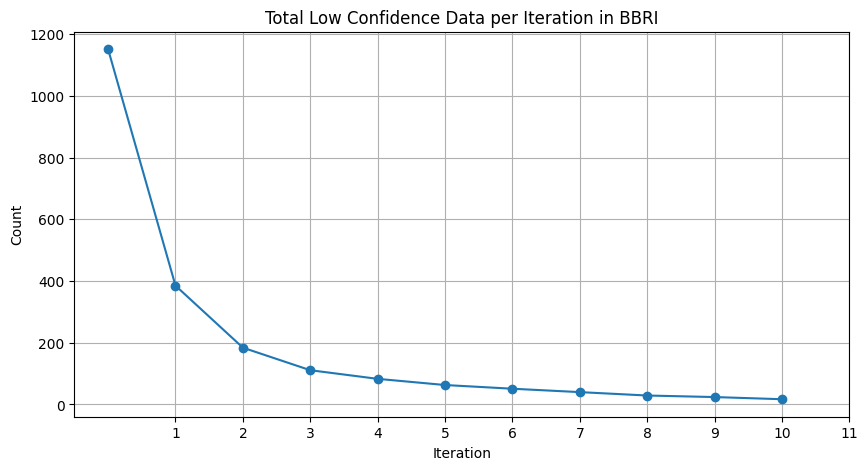

In [ ]:
emiten = "BBRI"
plot_length(count_len_bbri, emiten)

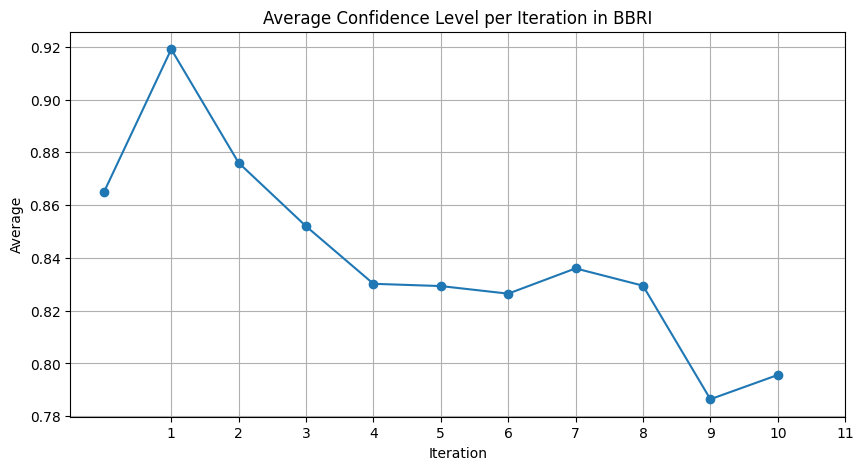

In [ ]:
plot_avg_conf(avg_conf_count_bbri, emiten)

In [ ]:
# Save Labels after looping for all scenarios
# pseudo_1.to_csv("./Dataset/All_Scenario_Pseudolabel.csv")

## Making Total and Majority Sentiment

In [ ]:
import pandas as pd

# List of stock symbols
stocks = ["BBRI", "BMRI", "BBCA", "BBNI", "BBTN", "SMGR", "BRPT", "INTP", "INCO", "MDKA"]

# Import the pseudolabeling scenarios
all_sen = pd.read_csv('./Dataset/All_Scenario_Pseudolabel.csv')

# For all emiten
all_sen = all_sen.drop(columns=['title', 'text', 'Unnamed: 0', 'label_2', 'label_3'], axis=1)

# Fill missing 'label_1' values
all_sen.loc[:, 'label_1'] = all_sen['label_1'].fillna(0)

# Convert 'published_date' to datetime format (if not already)
all_sen['Date'] = pd.to_datetime(all_sen['published_date'])

# Set 'published_date' as the index
all_sen.set_index('Date', inplace=True)

# Sort the DataFrame based on the index (oldest to most recent)
all_sen.sort_index(inplace=True)

# For one emiten
for stock in stocks:
    sen_df = all_sen[all_sen['kode_emitten'] == stock].copy()
    sen_df.loc[:, 'label_1'] = sen_df['label_1'].fillna(0)
    sen_df['Date'] = pd.to_datetime(sen_df['published_date'])
    sen_df.set_index('Date', inplace=True)
    sen_df.sort_index(inplace=True)

    globals()[f"sen_{stock.lower()}"] = sen_df

sen_bbri

,published_date,kode_emitten,label_1
Date,,,
2018-09-07,2018-09-07,BBRI,0.0
2018-09-19,2018-09-19,BBRI,0.0
2018-09-28,2018-09-28,BBRI,0.0
2018-10-07,2018-10-07,BBRI,0.0
2018-10-24,2018-10-24,BBRI,1.0
...,...,...,...
2023-09-29,2023-09-29,BBRI,0.0
2023-09-29,2023-09-29,BBRI,0.0
2023-09-29,2023-09-29,BBRI,0.0


In [ ]:
# Create Total Label ad Majority Label based on the previously labeled data
for stock in stocks:
    sen_df = globals()[f"sen_{stock.lower()}"]
    sen_df['total_label'] = sen_df.groupby('Date').agg({'label_1': 'sum'})
    globals()[f"sen_{stock.lower()}"] = sen_df

for stock in stocks:
    sen_df = globals()[f"sen_{stock.lower()}"]
    sen_df['majority_label'] = sen_df.groupby(sen_df.index.date)['label_1'].agg(lambda x:x.value_counts().index[0])
    sen_df = sen_df.drop_duplicates(subset='published_date')
    sen_df = sen_df.drop(columns=['published_date', 'label_1', 'kode_emitten'], axis=1)
    globals()[f"sen_{stock.lower()}"] = sen_df

sen_bbri.head(10)

,total_label,majority_label
Date,,
2018-09-07,0.0,0.0
2018-09-19,0.0,0.0
2018-09-28,0.0,0.0
2018-10-07,0.0,0.0
2018-10-24,1.0,1.0
2018-11-15,0.0,0.0
2018-11-30,0.0,0.0
2018-12-21,0.0,0.0
2018-12-26,0.0,0.0


# Historical Data

## Collecting Historical Data

In [ ]:
import yfinance as yf
yf.pdr_override()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [ ]:
# Define your start_date and end_date
start = '2018-09-01'
end = '2023-09-30'

tech_list = ['BBRI.JK', 'BMRI.JK', 'BBCA', 'BBNI.JK', 'BBTN.JK', 'SMGR.JK', 'BRPT.JK', 'INTP.JK', 'INCO.JK', 'MDKA.JK']
stocks_list = ['BBRI', 'BMRI', 'BBCA', 'BBNI', 'BBTN', 'SMGR', 'BRPT', 'INTP', 'INCO', 'MDKA']
pick_emiten = 0

# Get historical data using yfinance
def analyze_stock(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    stock_data['Code'] = stock_symbol
    stock_data = stock_data.dropna()
    return stock_data

# Input usages
df = analyze_stock(tech_list[pick_emiten],start,end)

stock = df['Code'] = stocks_list[pick_emiten]
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Code
Date,,,,,,,
2023-01-02,4910.0,4920.0,4820.0,4870.0,4349.535645,100200100,BBRI
2023-01-03,4830.0,4900.0,4830.0,4850.0,4331.672852,95136500,BBRI
2023-01-04,4850.0,4850.0,4770.0,4770.0,4260.222656,188071000,BBRI
2023-01-05,4750.0,4760.0,4570.0,4640.0,4144.116211,292142000,BBRI
2023-01-06,4550.0,4640.0,4550.0,4620.0,4126.253418,175932000,BBRI
...,...,...,...,...,...,...,...
2023-09-22,5350.0,5425.0,5350.0,5350.0,5077.938965,83184100,BBRI
2023-09-25,5325.0,5350.0,5200.0,5300.0,5030.481934,120196700,BBRI
2023-09-26,5250.0,5275.0,5200.0,5200.0,4935.567383,180280600,BBRI


## Set up Technical Indicators

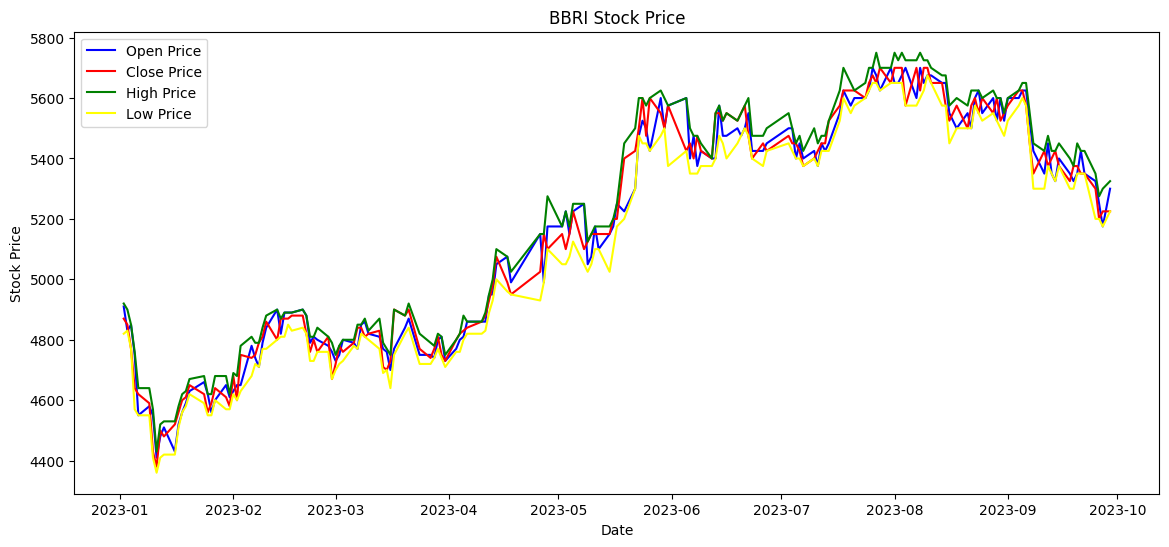

In [ ]:
# Plotting the previously obtained BBRI data
plt.figure(figsize=(14, 6))
plt.plot(df['Open'], label='Open Price', color='blue')
plt.plot(df['Close'], label='Close Price', color='red')
plt.plot(df['High'], label='High Price', color='green')
plt.plot(df['Low'], label='Low Price', color='yellow')

plt.title(f'{stock} Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# Calculate Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std=2):
    rolling_mean = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()
    df['Bollinger_Band_Middle'] = rolling_mean
    df['Bollinger_Band_Upper'] = rolling_mean + (rolling_std * num_std)
    df['Bollinger_Band_Lower'] = rolling_mean - (rolling_std * num_std)

calculate_bollinger_bands(df)

# Calculate RSI
def calculate_rsi(df, window=14):
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

calculate_rsi(df)

In [ ]:
# Calculate 5-day, 10-day, 20-day, and 50-day EMAs
# was only 12 and 16
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

# Calculate 5-day, 10-day, 20-day, and 50-day Simple Moving Average (SMA) as a placeholder
# was only 200
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Calculate MACD line and Signal line
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

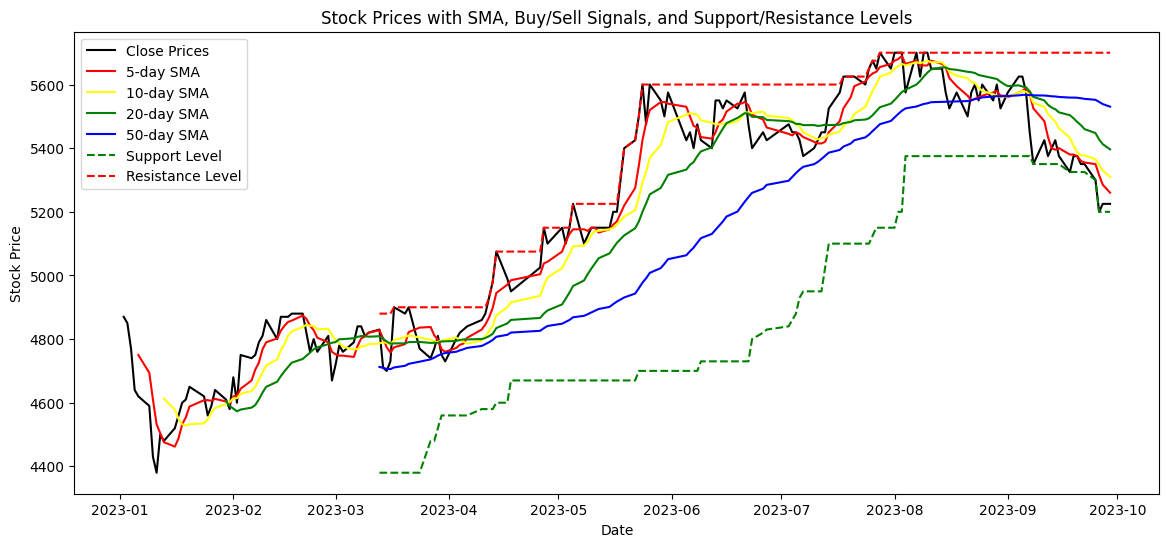

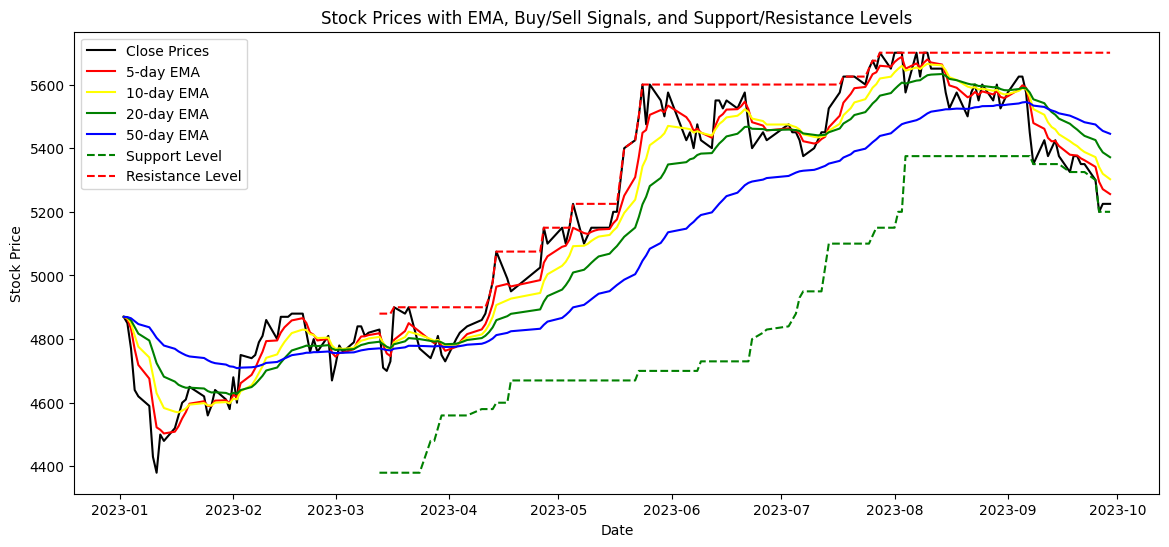

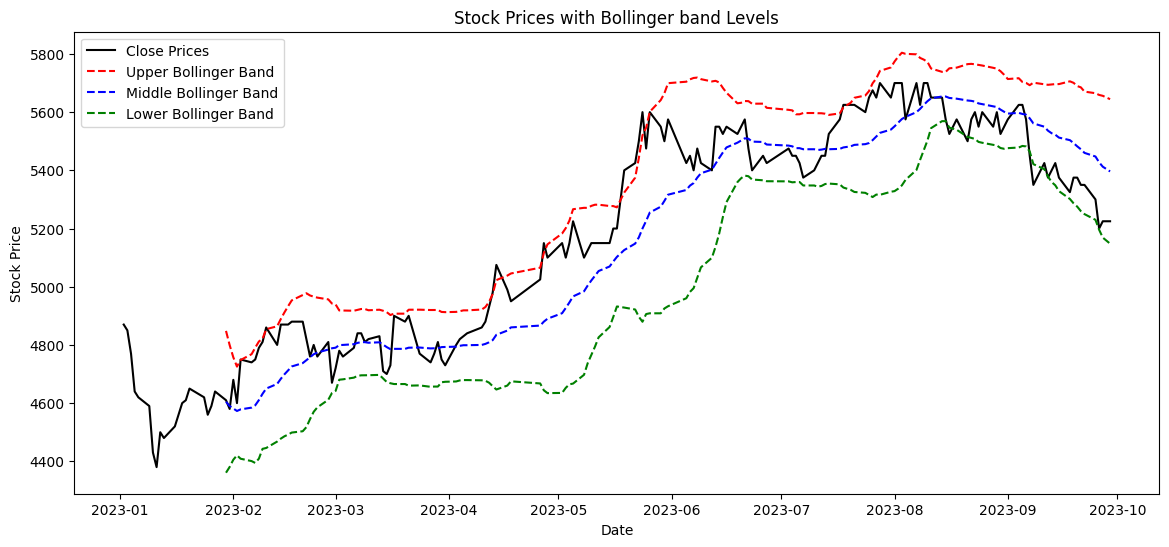

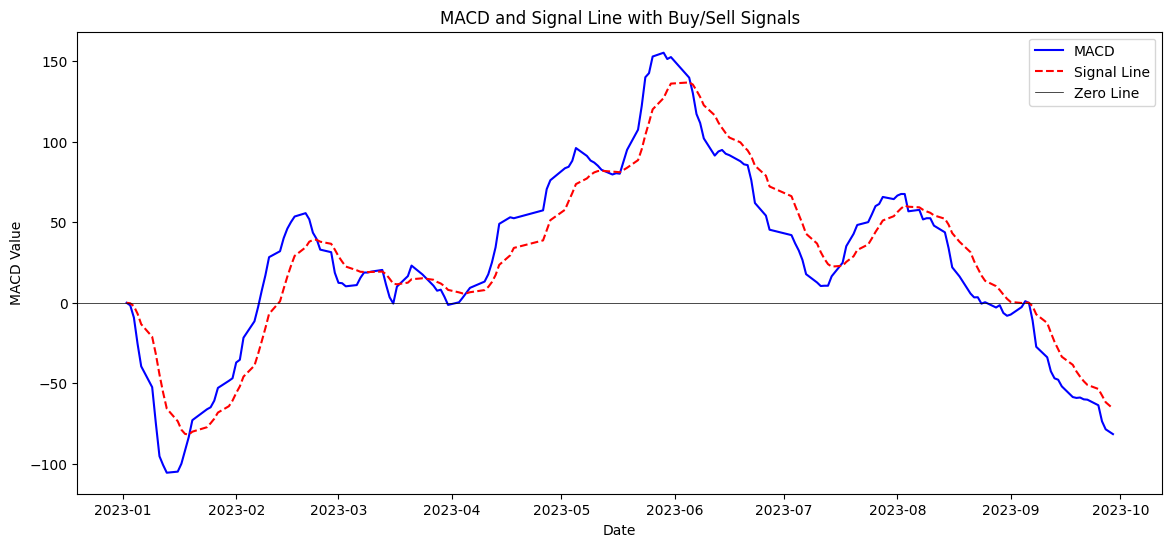

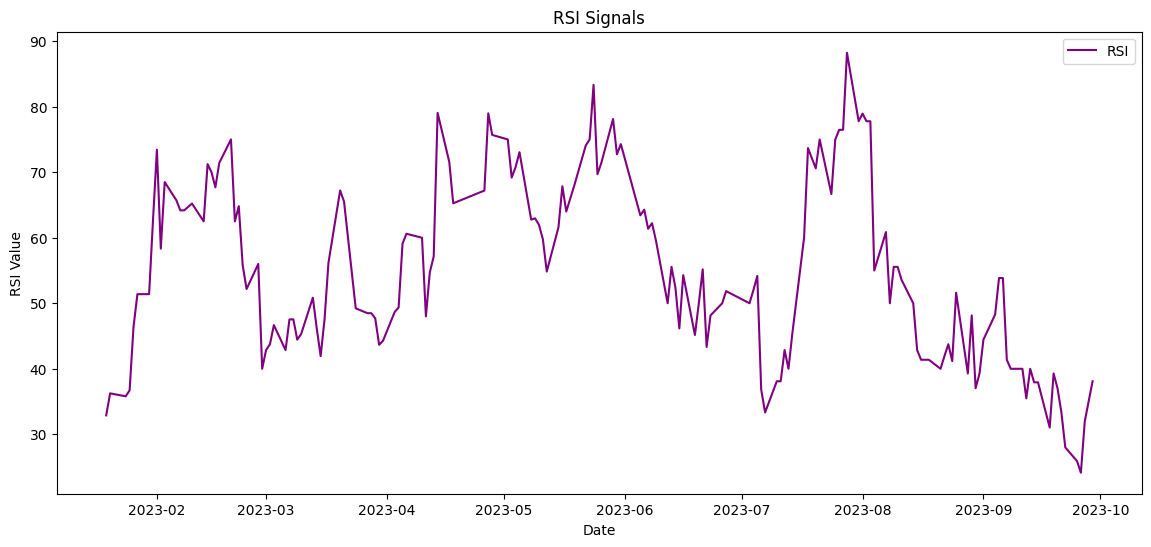

In [ ]:
import matplotlib.pyplot as plt

# Plotting Close Prices, SMA, and MACD
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Prices', color='black')
plt.plot(df['SMA_5'], label='5-day SMA', color='red')
plt.plot(df['SMA_10'], label='10-day SMA', color='yellow')
plt.plot(df['SMA_20'], label='20-day SMA', color='green')
plt.plot(df['SMA_50'], label='50-day SMA', color='blue')

# Add support and resistance levels (using min and max over a certain window as an example)
support_level = df['Close'].rolling(window=50).min()
resistance_level = df['Close'].rolling(window=50).max()
plt.plot(support_level, linestyle='--', color='green', label='Support Level')
plt.plot(resistance_level, linestyle='--', color='red', label='Resistance Level')

plt.title('Stock Prices with SMA, Buy/Sell Signals, and Support/Resistance Levels')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plotting Close Prices, EMA, and MACD
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Prices', color='black')
plt.plot(df['EMA_5'], label='5-day EMA', color='red')
plt.plot(df['EMA_10'], label='10-day EMA', color='yellow')
plt.plot(df['EMA_20'], label='20-day EMA', color='green')
plt.plot(df['EMA_50'], label='50-day EMA', color='blue')

# Add support and resistance levels (using min and max over a certain window as an example)
support_level = df['Close'].rolling(window=50).min()
resistance_level = df['Close'].rolling(window=50).max()
plt.plot(support_level, linestyle='--', color='green', label='Support Level')
plt.plot(resistance_level, linestyle='--', color='red', label='Resistance Level')

plt.title('Stock Prices with EMA, Buy/Sell Signals, and Support/Resistance Levels')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot Bollinger Bands
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Prices', color='black')
plt.plot(df['Bollinger_Band_Upper'], label='Upper Bollinger Band', linestyle='--', color='red')
plt.plot(df['Bollinger_Band_Middle'], label='Middle Bollinger Band', linestyle='--', color='blue')
plt.plot(df['Bollinger_Band_Lower'], label='Lower Bollinger Band', linestyle='--', color='green')

plt.title('Stock Prices with Bollinger band Levels')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plotting MACD and Signal Line
plt.figure(figsize=(14, 6))
plt.plot(df['MACD'], label='MACD', color='blue')
plt.plot(df['Signal_Line'], label='Signal Line', linestyle='--', color='red')

# Add a horizontal line at zero
plt.axhline(y=0, linestyle='-', color='black', linewidth=0.5, label='Zero Line')

plt.title('MACD and Signal Line with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(df['RSI'], label='RSI', color='purple')
plt.title('RSI Signals')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.show()

## Set up Action Label

In [ ]:
# Set target for 4 labels (Sell, Weak Sell, Weak Buy, Buy)
def set_target(dataframe, days, price_col, percent_threshold):
    target = 'None'
    chg = 0
    for i in range(dataframe.shape[0] - days):
        tod_price = dataframe.loc[i, price_col]
        fut_price = dataframe.loc[i + days, price_col]
        chg = ((fut_price - tod_price) / tod_price) * 100
        if fut_price > tod_price and chg >= percent_threshold:
            target = 4 # buy
        elif fut_price > tod_price and chg < percent_threshold:
            target = 3 # weak buy
        elif fut_price <= tod_price and abs(chg) >= percent_threshold:
            target = 1 # sell
        elif fut_price <= tod_price and abs(chg) < percent_threshold:
            target = 2 # weak sell
        dataframe.loc[i, f"target_{days}"] = target
    return dataframe

# Set the labels for all emiten
for stock_df in stocks_df:

    df_merge_copy = globals()[stock_df].copy()
    df_merge_copy = set_target(df_merge_copy, 5, "Close", 3)
    df_merge_copy = set_target(df_merge_copy, 10, "Close", 6)
    df_merge_copy = set_target(df_merge_copy, 20, "Close", 9)
    df_merge_copy = set_target(df_merge_copy, 50, "Close", 13)
    df_merge_copy = df_merge_copy.iloc[:-50]

    # Convert 'Date' to datetime format (if not already)
    df_merge_copy['Date'] = pd.to_datetime(df_merge_copy['Date'])
    # Set 'Date' as the index
    df_merge_copy.set_index('Date', inplace=True)

    globals()[f"hist_{stock_df}"] = df_merge_copy.copy()

hist_bbri_df

<ipython-input-4-a0ab6d42e8f9>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_copy['Date'] = pd.to_datetime(df_merge_copy['Date'])
<ipython-input-4-a0ab6d42e8f9>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_copy['Date'] = pd.to_datetime(df_merge_copy['Date'])
<ipython-input-4-a0ab6d42e8f9>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,Open,High,Low,Close,Adj Close,Volume,Code,Bollinger_Band_Middle,Bollinger_Band_Upper,Bollinger_Band_Lower,...,SMA_5,SMA_10,SMA_20,SMA_50,MACD,Signal_Line,target_5,target_10,target_20,target_50
Date,,,,,,,,,,,,,,,,,,,,,
2018-09-03,2890.859131,2927.222168,2872.677734,2881.768311,2246.718994,70837593,BBRI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,1.0,1.0,3.0,3.0
2018-09-04,2909.040771,2909.040771,2809.042480,2827.223877,2204.194580,83758086,BBRI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-4.351123,-0.870225,1.0,2.0,2.0,3.0
2018-09-05,2790.860840,2790.860840,2636.318115,2663.590332,2076.620605,233835878,BBRI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-20.763925,-4.848965,2.0,3.0,3.0,4.0
2018-09-06,2645.408936,2718.134766,2645.408936,2690.862549,2097.883057,226602703,BBRI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-31.210771,-10.121326,3.0,3.0,3.0,4.0
2018-09-07,2709.044189,2754.497803,2690.862549,2754.497803,2147.494873,155714509,BBRI,NaN,NaN,NaN,...,2763.588574,NaN,NaN,NaN,-33.963627,-14.889786,3.0,3.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-12,5450.000000,5475.000000,5425.000000,5450.000000,5172.854004,104993700,BBRI,5471.25,5596.144692,5346.355308,...,5415.000000,5432.5,5471.25,5366.0,10.591415,27.345438,4.0,3.0,3.0,2.0
2023-07-13,5425.000000,5475.000000,5425.000000,5450.000000,5172.854004,134905700,BBRI,5473.75,5594.575015,5352.924985,...,5420.000000,5432.5,5473.75,5376.0,10.597850,23.995920,4.0,3.0,3.0,2.0
2023-07-14,5450.000000,5525.000000,5425.000000,5525.000000,5244.040039,127814200,BBRI,5472.50,5590.487510,5354.512490,...,5450.000000,5442.5,5472.50,5386.0,16.465025,22.489741,3.0,3.0,3.0,2.0


In [ ]:
# Label descriptions:
# 1 = Sell
# 2 = Weak Sell
# 3 = Weak Buy
# 4 = Buy

print(f"{hist_bbri_df['target_5'].value_counts()}")
print(f"{hist_bbri_df['target_10'].value_counts()}")
print(f"{hist_bbri_df['target_20'].value_counts()}")
print(f"{hist_bbri_df['target_50'].value_counts()}")

target_5
2.0    408
3.0    369
4.0    253
1.0    175
Name: count, dtype: int64
target_10
3.0    489
2.0    426
4.0    171
1.0    119
Name: count, dtype: int64
target_20
3.0    567
2.0    381
4.0    156
1.0    101
Name: count, dtype: int64
target_50
3.0    524
2.0    373
4.0    234
1.0     74
Name: count, dtype: int64


In [ ]:
# UNCOMMENT TO SAVE DATA
# df.to_csv(f"/content/drive/MyDrive/TA_Saham/Raw_Data/{stock}/Bisnis_{stock}.csv")

# Merge Historical and Sentiment Data

In [ ]:
for stock in stocks:
    # Merge the calculated daily modes back into stock_df based on 'published_date'
    merged_df = globals()[f"{stock.lower()}_df"].merge(globals()[f"sen_{stock.lower()}"], left_index=True, right_index=True, how='left')
    merged_df = merged_df.drop(columns=['Adj Close'], axis=1)

    # Fill NaN value for the sentiment data
    merged_df["majority_label"] = merged_df["majority_label"].fillna(0)
    merged_df["total_label"] = merged_df["total_label"].fillna(0)

    # Remove the first and last 50 rows from the DataFrame
    merged_df = merged_df.drop(merged_df.head(50).index)
    merged_df = merged_df.drop(merged_df.tail(50).index)

    globals()[f"merged_{stock.lower()}_df"] = merged_df

merged_bbri_df

,Open,High,Low,Close,Volume,Code,Bollinger_Band_Middle,Bollinger_Band_Upper,Bollinger_Band_Lower,RSI,...,SMA_50,MACD,Signal_Line,Action_1,Action_5,Action_10,Action_20,Action_50,total_label,majority_label
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-12,3018.129639,3054.492676,2981.766602,2981.766602,84809154,BBRI,2856.314331,3143.825478,2568.803184,65.116277,...,2788.860933,76.962940,51.239246,4.0,4.0,4.0,4.0,4.0,0.0,0.0
2018-11-13,2981.766602,3054.492676,2936.312988,3045.401855,112074555,BBRI,2872.223145,3164.825268,2579.621021,73.255815,...,2793.224492,78.663037,56.724004,3.0,4.0,4.0,4.0,3.0,0.0,0.0
2018-11-14,3045.401855,3109.037109,3045.401855,3045.401855,125174682,BBRI,2884.950195,3184.707114,2585.193277,71.604944,...,2800.860723,79.098577,61.198919,4.0,4.0,4.0,4.0,3.0,0.0,0.0
2018-11-15,3063.583496,3109.037109,3027.220459,3099.946533,117577840,BBRI,2899.495398,3211.715861,2587.274935,74.418624,...,2809.042402,82.889546,65.537044,4.0,4.0,4.0,4.0,3.0,0.0,0.0
2018-11-16,3118.127930,3227.217041,3109.037109,3172.672363,191148871,BBRI,2920.858655,3246.852648,2594.864661,79.999994,...,2817.405894,90.716558,70.572947,3.0,2.0,4.0,4.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-12,5450.000000,5475.000000,5425.000000,5450.000000,104993700,BBRI,5471.250000,5596.144692,5346.355308,42.857143,...,5366.000000,10.591415,27.345438,3.0,4.0,4.0,4.0,2.0,0.0,0.0
2023-07-13,5425.000000,5475.000000,5425.000000,5450.000000,134905700,BBRI,5473.750000,5594.575015,5352.924985,40.000000,...,5376.000000,10.597850,23.995920,4.0,4.0,4.0,4.0,2.0,0.0,0.0
2023-07-14,5450.000000,5525.000000,5425.000000,5525.000000,127814200,BBRI,5472.500000,5590.487510,5354.512490,45.454545,...,5386.000000,16.465025,22.489741,3.0,4.0,4.0,4.0,2.0,2.0,0.0


In [ ]:
# Set the target strategy for 50 days
for stock, stock_df in zip(stocks, stocks_df):
    df = globals()[f"merged_{stock_df}"]

    # Target 50 days
    df_50 = df.drop(columns=['Action_1', 'Action_5', 'Action_10', 'Action_20'], axis=1)
    df_50.rename(columns={'Action_50': 'Action'}, inplace=True)
    df_50 = pd.get_dummies(df_50, columns=['Code'])
    globals()[f"df50_{stock.lower()}"] = df_50.copy()

# Classification

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split

In [ ]:
# Use dataframe for classification
df = df50_bbri

,Open,High,Low,Close,Volume,Bollinger_Band_Middle,Bollinger_Band_Upper,Bollinger_Band_Lower,RSI,EMA_5,...,SMA_5,SMA_10,SMA_20,SMA_50,MACD,Signal_Line,Action,total_label,majority_label,Code_BBRI
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-12,3018.129639,3054.492676,2981.766602,2981.766602,84809154,2856.314331,3143.825478,2568.803184,65.116277,3017.842330,...,3049.038281,2972.675952,2856.314331,2788.860933,76.962940,51.239246,4.0,0.0,0.0,True
2018-11-13,2981.766602,3054.492676,2936.312988,3045.401855,112074555,2872.223145,3164.825268,2579.621021,73.255815,3027.028839,...,3052.674561,3001.766357,2872.223145,2793.224492,78.663037,56.724004,3.0,0.0,0.0,True
2018-11-14,3045.401855,3109.037109,3045.401855,3045.401855,125174682,2884.950195,3184.707114,2585.193277,71.604944,3033.153178,...,3049.038232,3019.947852,2884.950195,2800.860723,79.098577,61.198919,3.0,0.0,0.0,True
2018-11-15,3063.583496,3109.037109,3027.220459,3099.946533,117577840,2899.495398,3211.715861,2587.274935,74.418624,3055.417629,...,3041.765625,3039.038428,2899.495398,2809.042402,82.889546,65.537044,3.0,0.0,0.0,True
2018-11-16,3118.127930,3227.217041,3109.037109,3172.672363,191148871,2920.858655,3246.852648,2594.864661,79.999994,3094.502541,...,3069.037842,3058.129004,2920.858655,2817.405894,90.716558,70.572947,3.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-12,5450.000000,5475.000000,5425.000000,5450.000000,104993700,5471.250000,5596.144692,5346.355308,42.857143,5428.694297,...,5415.000000,5432.500000,5471.250000,5366.000000,10.591415,27.345438,2.0,0.0,0.0,True
2023-07-13,5425.000000,5475.000000,5425.000000,5450.000000,134905700,5473.750000,5594.575015,5352.924985,40.000000,5435.796198,...,5420.000000,5432.500000,5473.750000,5376.000000,10.597850,23.995920,2.0,0.0,0.0,True
2023-07-14,5450.000000,5525.000000,5425.000000,5525.000000,127814200,5472.500000,5590.487510,5354.512490,45.454545,5465.530799,...,5450.000000,5442.500000,5472.500000,5386.000000,16.465025,22.489741,2.0,2.0,0.0,True


In [ ]:
# View the label distributions
print(f"{df['Action'].value_counts()}\n")

Action
3.0    534
2.0    359
4.0    188
1.0     74
Name: count, dtype: int64



In [ ]:
# View the features and labels
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1155 entries, 2018-11-12 to 2023-07-18
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open                   1155 non-null   float64
 1   High                   1155 non-null   float64
 2   Low                    1155 non-null   float64
 3   Close                  1155 non-null   float64
 4   Volume                 1155 non-null   int64  
 5   Bollinger_Band_Middle  1155 non-null   float64
 6   Bollinger_Band_Upper   1155 non-null   float64
 7   Bollinger_Band_Lower   1155 non-null   float64
 8   RSI                    1155 non-null   float64
 9   EMA_5                  1155 non-null   float64
 10  EMA_10                 1155 non-null   float64
 11  EMA_20                 1155 non-null   float64
 12  EMA_50                 1155 non-null   float64
 13  SMA_5                  1155 non-null   float64
 14  SMA_10                 1155 non-null  

## Set up features and labels

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

scaler = StandardScaler()

# Selecting features and target
X = df.drop(columns=['Action'], axis=1).values
y = df['Action'].values
y = to_categorical(y + 1) # add 1 to make categories start from 0

print("X: ", X.shape)
print("y: ", y.shape)

X:  (1155, 22)
y:  (1155, 6)


In [ ]:
# Create sliding window
window_size = 30  # Set window

def create_sequences(data, labels, window_size):
    sequences = []
    output = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:(i + window_size)])
        output.append(labels[i + window_size])
    return np.array(sequences), np.array(output)

X, y = create_sequences(X, y, window_size)
print("X: ", X.shape)
print("y: ", y.shape)

X:  (1125, 30, 22)
y:  (1125, 6)


In [ ]:
# Split Dataset
X_train, X_val, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Reshape the data
X_train_reshaped = X_train.reshape(-1, X_train.shape[2])
X_val_reshaped = X_val.reshape(-1, X_val.shape[2])

# Fit on the training data
scaler.fit(X_train_reshaped)

# Transform the data
X_train_scaled = scaler.transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)

# Reshape back to the original shape
train_X = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
val_X = X_val_scaled.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

In [ ]:
print("X_train: ", train_X.shape)
print("y_train: ", train_y.shape)
print("X_val: ", val_X.shape)
print("y_val", val_y.shape)

X_train:  (900, 30, 22)
y_train:  (900, 6)
X_val:  (225, 30, 22)
y_val (225, 6)


## Create Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, GRU, BatchNormalization, Input
from keras.optimizers import Adam

# LSTM Model
model_lstm = Sequential([
    Input(shape=(train_X.shape[1], train_X.shape[2])),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(train_y.shape[1], activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Bi-LSTM Model
model_bi_lstm = Sequential([
    Input(shape=(train_X.shape[1], train_X.shape[2])),
    Bidirectional(LSTM(50, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(50)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(train_y.shape[1], activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model_bi_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# GRU Model
model_gru = Sequential([
    Input(shape=(train_X.shape[1], train_X.shape[2])),
    GRU(50, return_sequences=True),
    Dropout(0.2),
    GRU(50),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(train_y.shape[1], activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model_gru.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Bi-GRU Model
model_bi_gru = Sequential([
    Input(shape=(train_X.shape[1], train_X.shape[2])),
    Bidirectional(GRU(50, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(GRU(50)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(train_y.shape[1], activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model_bi_gru.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [ ]:
# Train the LSTM model
history_lstm = model_lstm.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=2)

Epoch 1/100
29/29 - 7s - loss: 1.5341 - accuracy: 0.3267 - precision: 0.5556 - recall: 0.0056 - val_loss: 1.2599 - val_accuracy: 0.4222 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 7s/epoch - 252ms/step
Epoch 2/100
29/29 - 1s - loss: 1.0994 - accuracy: 0.5200 - precision: 0.5607 - recall: 0.2411 - val_loss: 1.0675 - val_accuracy: 0.5244 - val_precision: 0.5000 - val_recall: 0.2444 - 904ms/epoch - 31ms/step
Epoch 3/100
29/29 - 2s - loss: 0.9806 - accuracy: 0.5889 - precision: 0.6263 - recall: 0.3967 - val_loss: 0.9932 - val_accuracy: 0.5600 - val_precision: 0.5714 - val_recall: 0.4800 - 2s/epoch - 53ms/step
Epoch 4/100
29/29 - 2s - loss: 0.8812 - accuracy: 0.6444 - precision: 0.6809 - recall: 0.5122 - val_loss: 0.9110 - val_accuracy: 0.6000 - val_precision: 0.6184 - val_recall: 0.5689 - 2s/epoch - 65ms/step
Epoch 5/100
29/29 - 2s - loss: 0.8095 - accuracy: 0.6822 - precision: 0.7089 - recall: 0.6278 - val_loss: 0.8531 - val_accuracy: 0.6267 - val_precision: 0.6587 - val_recall

In [ ]:
# Train the Bi-LSTM model
history_bi_lstm = model_bi_lstm.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=2)

Epoch 1/100
29/29 - 16s - loss: 1.3692 - accuracy: 0.4556 - precision: 0.5783 - recall: 0.1067 - val_loss: 1.1506 - val_accuracy: 0.4578 - val_precision: 0.4909 - val_recall: 0.2400 - 16s/epoch - 547ms/step
Epoch 2/100
29/29 - 2s - loss: 0.9790 - accuracy: 0.5967 - precision: 0.6652 - recall: 0.3467 - val_loss: 0.9651 - val_accuracy: 0.5378 - val_precision: 0.5966 - val_recall: 0.4667 - 2s/epoch - 57ms/step
Epoch 3/100
29/29 - 2s - loss: 0.8485 - accuracy: 0.6456 - precision: 0.6819 - recall: 0.5478 - val_loss: 0.9683 - val_accuracy: 0.6000 - val_precision: 0.5980 - val_recall: 0.5422 - 2s/epoch - 54ms/step
Epoch 4/100
29/29 - 3s - loss: 0.7819 - accuracy: 0.6933 - precision: 0.7112 - recall: 0.6156 - val_loss: 0.8522 - val_accuracy: 0.6622 - val_precision: 0.6765 - val_recall: 0.6133 - 3s/epoch - 94ms/step
Epoch 5/100
29/29 - 3s - loss: 0.6951 - accuracy: 0.7356 - precision: 0.7579 - recall: 0.6922 - val_loss: 0.7757 - val_accuracy: 0.7289 - val_precision: 0.7465 - val_recall: 0.7200 

In [ ]:
# Train the GRU model
history_gru = model_gru.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=2)

Epoch 1/100
29/29 - 7s - loss: 1.4678 - accuracy: 0.4200 - precision: 0.4957 - recall: 0.0633 - val_loss: 1.2862 - val_accuracy: 0.3956 - val_precision: 0.4476 - val_recall: 0.2089 - 7s/epoch - 253ms/step
Epoch 2/100
29/29 - 1s - loss: 1.1353 - accuracy: 0.4789 - precision: 0.5584 - recall: 0.2444 - val_loss: 1.1542 - val_accuracy: 0.4711 - val_precision: 0.4699 - val_recall: 0.1733 - 927ms/epoch - 32ms/step
Epoch 3/100
29/29 - 1s - loss: 1.0512 - accuracy: 0.5256 - precision: 0.5780 - recall: 0.2800 - val_loss: 1.0572 - val_accuracy: 0.5289 - val_precision: 0.5366 - val_recall: 0.2933 - 1s/epoch - 35ms/step
Epoch 4/100
29/29 - 1s - loss: 0.9619 - accuracy: 0.5822 - precision: 0.6335 - recall: 0.3822 - val_loss: 0.9773 - val_accuracy: 0.5600 - val_precision: 0.6036 - val_recall: 0.4533 - 883ms/epoch - 30ms/step
Epoch 5/100
29/29 - 1s - loss: 0.8848 - accuracy: 0.6267 - precision: 0.6541 - recall: 0.5000 - val_loss: 0.9224 - val_accuracy: 0.5822 - val_precision: 0.6085 - val_recall: 0.5

In [ ]:
# Train the Bi-GRU model
history_bi_gru = model_bi_gru.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=2)

Epoch 1/100
29/29 - 13s - loss: 1.2945 - accuracy: 0.5033 - precision: 0.6147 - recall: 0.1578 - val_loss: 1.1285 - val_accuracy: 0.4889 - val_precision: 0.4929 - val_recall: 0.3067 - 13s/epoch - 458ms/step
Epoch 2/100
29/29 - 2s - loss: 0.9774 - accuracy: 0.5933 - precision: 0.6471 - recall: 0.3911 - val_loss: 1.0299 - val_accuracy: 0.5156 - val_precision: 0.5444 - val_recall: 0.4356 - 2s/epoch - 58ms/step
Epoch 3/100
29/29 - 2s - loss: 0.9027 - accuracy: 0.6300 - precision: 0.6681 - recall: 0.5122 - val_loss: 0.9346 - val_accuracy: 0.5778 - val_precision: 0.6045 - val_recall: 0.4756 - 2s/epoch - 52ms/step
Epoch 4/100
29/29 - 2s - loss: 0.8264 - accuracy: 0.6733 - precision: 0.7135 - recall: 0.5756 - val_loss: 0.8593 - val_accuracy: 0.6533 - val_precision: 0.6700 - val_recall: 0.5956 - 2s/epoch - 82ms/step
Epoch 5/100
29/29 - 3s - loss: 0.7801 - accuracy: 0.6744 - precision: 0.7226 - recall: 0.6078 - val_loss: 0.8489 - val_accuracy: 0.6844 - val_precision: 0.6810 - val_recall: 0.6356 

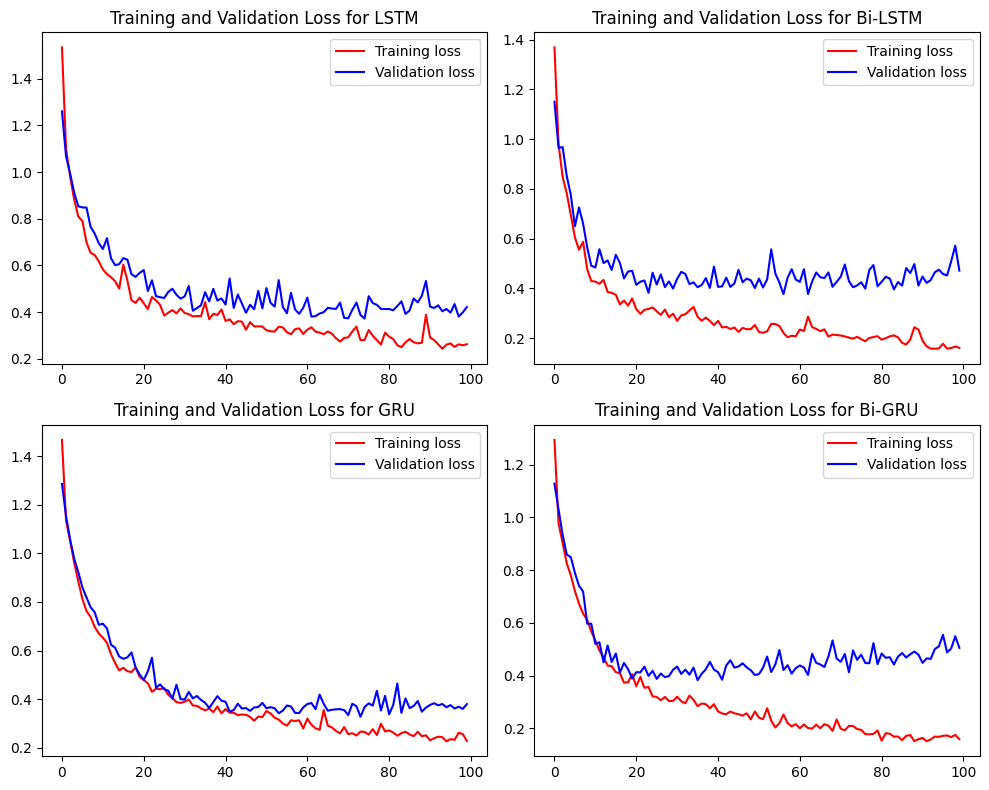

In [ ]:
import matplotlib.pyplot as plt

# List of histories
histories = [history_lstm, history_bi_lstm, history_gru, history_bi_gru]

# Corresponding model names
model_names = ['LSTM', 'Bi-LSTM', 'GRU', 'Bi-GRU']

# Create a 2x2 grid for subplots (which will fit 5 plots perfectly)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, model_history in enumerate(histories):
    # Determine the subplot location
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    # Get loss and validation loss
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    # Get number of epochs
    epochs = range(len(loss))

    # Plot training and validation loss
    ax.plot(epochs, loss, 'r', label='Training loss')
    ax.plot(epochs, val_loss, 'b', label='Validation loss')
    ax.set_title(f'Training and Validation Loss for {model_names[i]}')
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from scipy.stats import mode

def evaluate_model(model, model_name, val_X, val_y):
    # Stack predictions for RNN models
    model_pred = model.predict(val_X)
    model_pred = np.argmax(model_pred, axis=1) - 1 # subtract 1 to get original categories

    val_y = np.argmax(val_y, axis=1) - 1 # get original categories

    # Classification report
    print(f"{model_name} Evaluation\n")
    print(classification_report(val_y, model_pred, digits=4))
    return model_pred

def ensemble(pred_lstm, pred_bi_lstm, pred_gru, pred_bi_gru, val_X, val_y):
    # Stack predictions to perform majority voting for All Models
    all_predictions = np.stack((pred_lstm, pred_bi_lstm, pred_gru, pred_bi_gru), axis=1)

    # Perform majority voting
    voted_predictions, _ = mode(all_predictions, axis=1)

    # Flatten the voted_predictions array
    voted_predictions = voted_predictions.ravel()

    val_y = np.argmax(val_y, axis=1) - 1 # get original categories

    # Classification report
    print("Voting Classifier (All Model)\n")
    print(classification_report(val_y, voted_predictions, digits=4))
    return voted_predictions

def ensemble_just_bi(pred_bi_lstm, pred_bi_gru, val_X, val_y):
    # Stack predictions to perform majority voting for Bidirectional Only
    all_predictions = np.stack((pred_bi_lstm, pred_bi_gru), axis=1)

    # Perform majority voting
    voted_predictions, _ = mode(all_predictions, axis=1)

    # Flatten the voted_predictions array
    voted_predictions = voted_predictions.ravel()

    val_y = np.argmax(val_y, axis=1) - 1 # get original categories

    # Classification report
    print("Voting Classifier (Bidirectional Only)\n")
    print(classification_report(val_y, voted_predictions, digits=4))
    return voted_predictions

In [ ]:
# Predict all the methods for comparison
print("Val Evaluation\n")
pred_lstm = evaluate_model(model_lstm, "LSTM", val_X, val_y)
pred_bi_lstm = evaluate_model(model_bi_lstm, "Bi-LSTM", val_X, val_y)
pred_gru = evaluate_model(model_gru, "GRU", val_X, val_y)
pred_bi_gru = evaluate_model(model_bi_gru, "Bi-GRU", val_X, val_y)

pred_ensemble = ensemble(pred_lstm, pred_bi_lstm, pred_gru, pred_bi_gru, val_X, val_y)
pred_ensemble_bi = ensemble_just_bi(pred_bi_lstm, pred_bi_gru, val_X, val_y)

Val Evaluation

8/8 [==============================] - 1s 10ms/step
LSTM Evaluation

              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        15
           2     0.9342    0.8875    0.9103        80
           3     0.8100    0.9310    0.8663        87
           4     0.9706    0.7674    0.8571        43

    accuracy                         0.8889       225
   macro avg     0.9287    0.8965    0.9084       225
weighted avg     0.8975    0.8889    0.8891       225

8/8 [==============================] - 2s 15ms/step
Bi-LSTM Evaluation

              precision    recall  f1-score   support

           1     0.8824    1.0000    0.9375        15
           2     0.9221    0.8875    0.9045        80
           3     0.8247    0.9195    0.8696        87
           4     0.9706    0.7674    0.8571        43

    accuracy                         0.8844       225
   macro avg     0.8999    0.8936    0.8922       225
weighted avg     0.8911    0

8/8 [==============================] - 0s 13ms/step


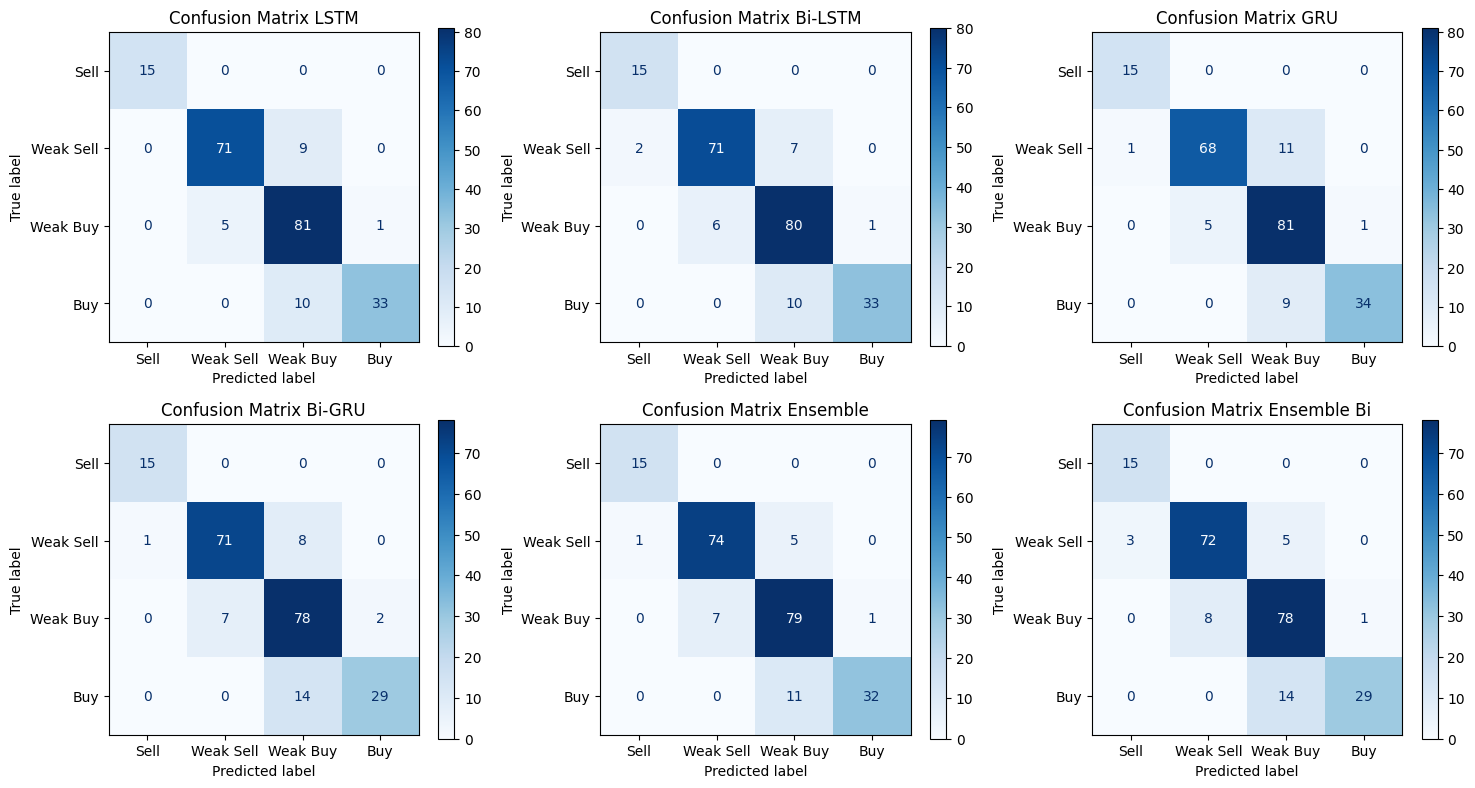

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Assuming model_names and model_predictions are already defined
model_names = ['LSTM', 'Bi-LSTM', 'GRU', 'Bi-GRU', 'Ensemble', 'Ensemble Bi']
models = [model_lstm, model_bi_lstm, model_gru, model_bi_gru]

fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # Now creating a grid of 3x2 for the extra ensemble plot
axs = axs.flatten()  # Flatten the array to make indexing easier

for i, model in enumerate(models):
    # Predict using the test set
    predicted_probabilities = model.predict(val_X)
    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    true_labels = np.argmax(val_y[-len(predicted_labels):], axis=1)  # Adjust based on the length of predictions

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sell', 'Weak Sell', 'Weak Buy', 'Buy'])
    disp.plot(ax=axs[i], cmap=plt.cm.Blues)
    axs[i].title.set_text(f"Confusion Matrix {model_names[i]}")

# Add ensemble model confusion matrix
true_labels = np.argmax(val_y, axis=1)-1
cm = confusion_matrix(true_labels, pred_ensemble)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sell', 'Weak Sell', 'Weak Buy', 'Buy'])
disp.plot(ax=axs[4], cmap=plt.cm.Blues)
axs[4].title.set_text("Confusion Matrix Ensemble")

cm = confusion_matrix(true_labels, pred_ensemble_bi)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sell', 'Weak Sell', 'Weak Buy', 'Buy'])
disp.plot(ax=axs[5], cmap=plt.cm.Blues)
axs[5].title.set_text("Confusion Matrix Ensemble Bi")

# Adjust layout
fig.tight_layout()
plt.show()